# Class-based LDS

* Gaussian LDS
* Poisson LDS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as np
import jax.random as jr
import jax.experimental.optimizers as optimizers
from jax import jit, value_and_grad, vmap
from tqdm.auto import trange

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

In [3]:
from ssm.models.lds import GaussianLDS
from ssm.distributions.linreg import GaussianLinearRegression

from ssm.utils import random_rotation
from ssm.plots import plot_dynamics_2d

## Let's instantiate a Linear Dynamical System (LDS)

In [4]:
emissions_dim = 3
latent_dim = 2
seed = jr.PRNGKey(0)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    0.1**2 * np.eye(latent_dim))

emissions_distribution = GaussianLinearRegression(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.zeros(emissions_dim), 
    1.0**2 * np.eye(emissions_dim))

true_lds = GaussianLDS(initial_distribution, 
                       dynamics_distribution,
                       emissions_distribution)

## Let's sample some data from the LDS

Being a state space model, we obtain the ground truth latent states as well as observations (data).

In [5]:
all_states, all_data = [], []

num_trials = 5
num_timesteps = 200

rng = jr.PRNGKey(0)
for i in trange(num_trials):
    rng, this_rng = jr.split(rng, 2)
    states, data = true_lds.sample(key=this_rng, num_steps=num_timesteps)
    all_states.append(states)
    all_data.append(data)

  0%|          | 0/5 [00:00<?, ?it/s]

### Plot the dynamics of the LDS

We can visualize the underlying linear dynamical system as a vector field. Then, we can overlay the sampled latent state trajectory on top of that.

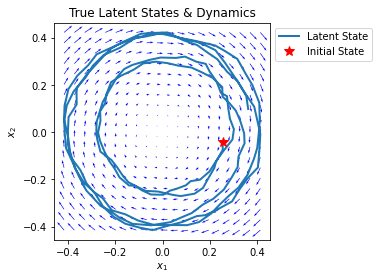

In [6]:
q = plot_dynamics_2d(true_lds.dynamics.distribution.weights, 
                     bias_vector=true_lds.dynamics.distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="blue")
plt.plot(states[:,0], states[:,1], lw=2, label="Latent State")
plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="Initial State")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("True Latent States & Dynamics")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Plot the emissions 

The observed data are the outputs from the emissions of our model.

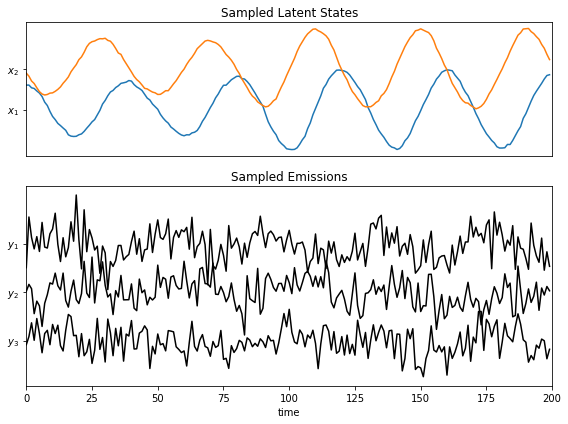

In [7]:
from matplotlib.gridspec import GridSpec 

plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

# Plot the continuous latent states
lim = abs(states).max()
plt.subplot(gs[0])
for d in range(latent_dim):
    plt.plot(states[:, d] + lim * d, '-')
plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
plt.xticks([])
plt.xlim(0, num_timesteps)
plt.title("Sampled Latent States")

lim = abs(data).max()
plt.subplot(gs[1])
for n in range(emissions_dim):
    plt.plot(data[:, n] - lim * n, '-k')
plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
plt.xlabel("time")
plt.xlim(0, num_timesteps)

plt.title("Sampled Emissions")
plt.tight_layout()

# Inference

Can we fit an LDS model to the data generated by our ground-truth LDS from above?

In [8]:
emissions_dim = 3
latent_dim = 2
seed = jr.PRNGKey(32)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    1.0**2 * np.eye(latent_dim))

emissions_distribution = GaussianLinearRegression(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.zeros(emissions_dim), 
    1.0**2 * np.eye(emissions_dim))

test_lds = GaussianLDS(initial_distribution, 
                       dynamics_distribution,
                       emissions_distribution)

### Using Exact EM

We can derive exact M steps for Gaussian LDS (LDS with Gaussian observations). Let's take advantage of those analytical solutions by fitting our `test_lds` using EM.

In [18]:
v_all_data = np.array(all_data)

In [19]:
J_diag, J_lower_diag, h = vmap(test_lds.natural_parameters)(v_all_data)

In [26]:
posteriors = vmap(test_lds.e_step)(v_all_data)

  0%|          | 0/100 [00:00<?, ?it/s]

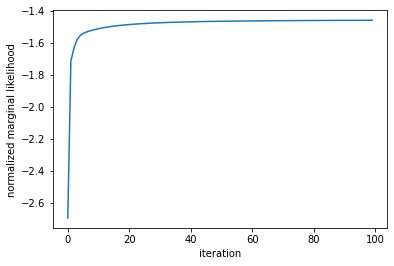

In [39]:
from ssm.inference.em import em

lps, fitted_lds, posteriors = em(test_lds, v_all_data, tol=-1)

plt.plot(lps / data.size)
plt.xlabel("iteration")
plt.ylabel("normalized marginal likelihood")
plt.show()

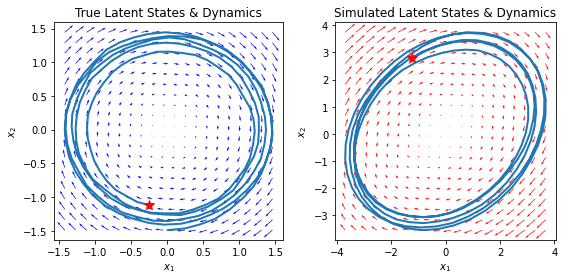

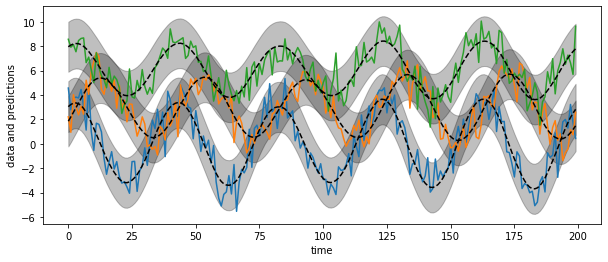

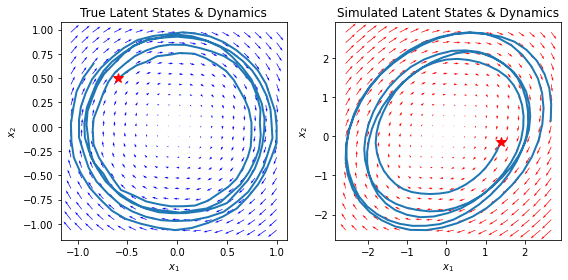

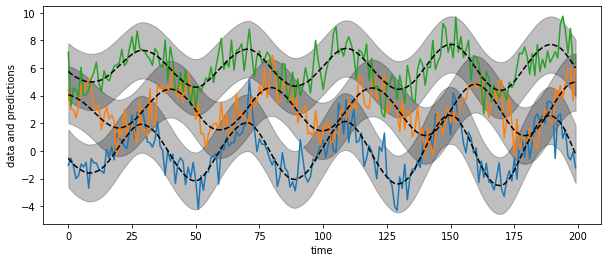

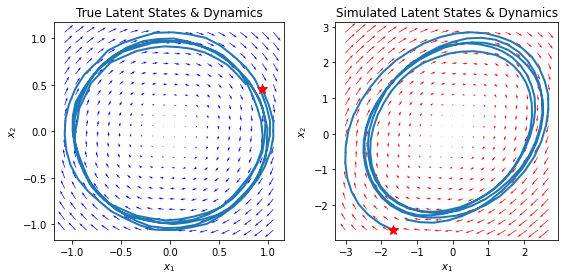

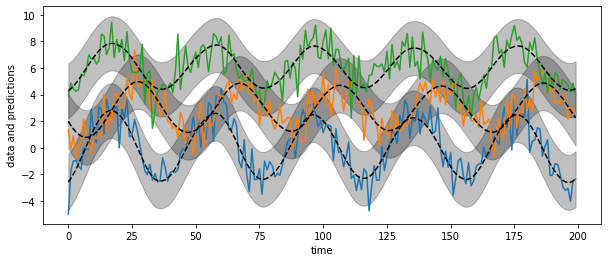

In [78]:
for trial_idx in range(3):

    Ex = posterior.mean[trial_idx]
    states = all_states[trial_idx]
    data = all_data[trial_idx]

    # Plot
    num_batches_to_plot = 5
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    q = plot_dynamics_2d(true_lds.dynamics.distribution.weights, 
                         bias_vector=true_lds.dynamics.distribution.bias,
                         mins=states.min(axis=0),
                         maxs=states.max(axis=0),
                         color="blue",
                         axis=axs[0])
    axs[0].plot(states[:,0], states[:,1], lw=2)
    axs[0].plot(states[0,0], states[0,1], '*r', markersize=10, label="$x_{init}$")
    axs[0].set_xlabel("$x_1$")
    axs[0].set_ylabel("$x_2$")
    axs[0].set_title("True Latent States & Dynamics")

    q = plot_dynamics_2d(fitted_lds.dynamics.distribution.weights, 
                         bias_vector=fitted_lds.dynamics.distribution.bias,
                         mins=Ex.min(axis=0),
                         maxs=Ex.max(axis=0),
                         color="red",
                         axis=axs[1])

    axs[1].plot(Ex[:,0], Ex[:,1], lw=2)
    axs[1].plot(Ex[0,0], Ex[0,1], '*r', markersize=10, label="$x_{init}$")
    axs[1].set_xlabel("$x_1$")
    axs[1].set_ylabel("$x_2$")
    axs[1].set_title("Simulated Latent States & Dynamics")
    plt.tight_layout()
    plt.show()

    # Compute the data predictions
    C = fitted_lds.emissions_matrix
    d = fitted_lds.emissions_bias
    R = fitted_lds.emissions_noise_covariance

    Ey = Ex @ C.T + d
    Covy = C @ posterior.covariance[trial_idx] @ C.T + R

    data_dim = data.shape[-1]

    plt.figure(figsize=(10, 4))
    plt.plot(data + 3 * np.arange(data_dim))
    plt.plot(Ey + 3 * np.arange(data_dim), '--k')
    for i in range(data_dim):
      plt.fill_between(np.arange(len(data)),
                       3 * i + Ey[:, i] - 2 * np.sqrt(Covy[:, i, i]),
                       3 * i + Ey[:, i] + 2 * np.sqrt(Covy[:, i, i]), 
                       color='k', alpha=0.25)
    plt.xlabel("time")
    plt.ylabel("data and predictions")
    plt.show()

# Poisson LDS

In [13]:
from ssm.models.lds import LDS
from ssm.distributions.glm import PoissonGLM, GaussianGLM

In [14]:
emissions_dim = 10  # num_neurons
latent_dim = 2
seed = jr.PRNGKey(0)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianGLM(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    0.1**2 * np.eye(latent_dim))

emissions_distribution = PoissonGLM(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.ones(emissions_dim))

true_lds = LDS(initial_distribution, 
               dynamics_distribution,
               emissions_distribution)

In [15]:
time_bins = 500
key = jr.PRNGKey(0)

import warnings
with warnings.catch_warnings():  # ignore annoying Poisson sampling warning
    warnings.filterwarnings('ignore', category=UserWarning)
    states, data = true_lds.sample(key=key, num_steps=time_bins)

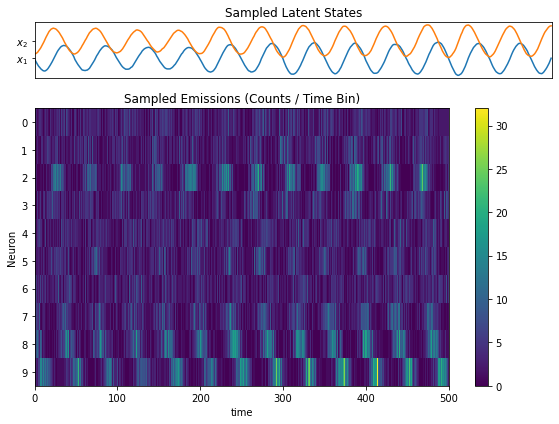

In [16]:
from matplotlib.gridspec import GridSpec 

plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

# Plot the continuous latent states
lim = abs(states).max()
plt.subplot(gs[0])
for d in range(latent_dim):
    plt.plot(states[:, d] + lim * d, '-')
plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Sampled Latent States")

lim = abs(data).max()
plt.subplot(gs[1])
plt.imshow(data.T, aspect="auto", interpolation="none")
plt.xlabel("time")
plt.xlim(0, time_bins)
plt.yticks(ticks=np.arange(emissions_dim))
plt.ylabel("Neuron")

plt.title("Sampled Emissions (Counts / Time Bin)")
plt.tight_layout()

plt.colorbar()

In [17]:
emissions_dim = 10  # num_neurons
latent_dim = 2
seed = jr.PRNGKey(32)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

# TODO: Using GaussianGLM class instead of GaussianLinearRegression leads to redundant JIT compilation step. Why?
# dynamics_distribution = GaussianGLM(
#     random_rotation(key1, latent_dim, theta=np.pi/20),
#     np.zeros(latent_dim), 
#     1.0**2 * np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    1.0**2 * np.eye(latent_dim))

emissions_distribution = PoissonGLM(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.ones(emissions_dim))

test_lds = LDS(initial_distribution, 
               dynamics_distribution,
               emissions_distribution)

In [18]:
from ssm.inference.laplace_em import laplace_em, _compute_laplace_mean

rng = jr.PRNGKey(10)
elbos, fitted_lds, posterior = laplace_em(rng, 
                                          test_lds,
                                          data,
                                          num_iters=100, 
                                          laplace_mode_fit_method="BFGS")

  0%|          | 0/100 [00:00<?, ?it/s]

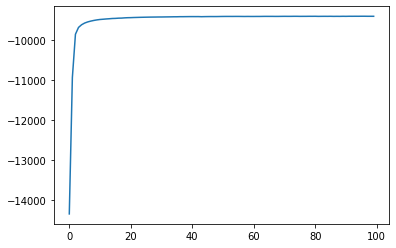

In [24]:
plt.plot(elbos)
plt.show()

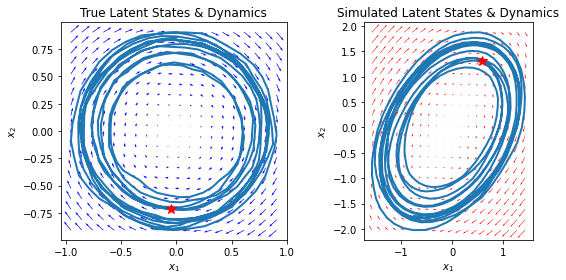

In [25]:
# Posterior Mean
Ex = posterior.mean

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

q = plot_dynamics_2d(true_lds.dynamics.distribution.weights, 
                     bias_vector=true_lds.dynamics.distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="blue",
                     axis=axs[0])
axs[0].plot(states[:,0], states[:,1], lw=2)
axs[0].plot(states[0,0], states[0,1], '*r', markersize=10, label="$x_{init}$")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
axs[0].set_title("True Latent States & Dynamics")

q = plot_dynamics_2d(fitted_lds.dynamics.distribution.weights, 
                     bias_vector=fitted_lds.dynamics.distribution.bias,
                     mins=Ex.min(axis=0),
                     maxs=Ex.max(axis=0),
                     color="red",
                     axis=axs[1])

axs[1].plot(Ex[:,0], posterior.mean[:,1], lw=2)
axs[1].plot(Ex[0,0], Ex[0,1], '*r', markersize=10, label="$x_{init}$")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].set_title("Simulated Latent States & Dynamics")
plt.tight_layout()
plt.show()

In [26]:
# Compute the data predictions
Ex = posterior.mean
C = fitted_lds.emissions_matrix
d = fitted_lds.emissions_bias

Ey = Ex @ C.T + d
Covy = C @ posterior.covariance @ C.T

In [27]:
# basically recover the "true" input to the Poisson GLM
Ey_true = states @ true_lds.emissions_matrix.T + true_lds.emissions_bias

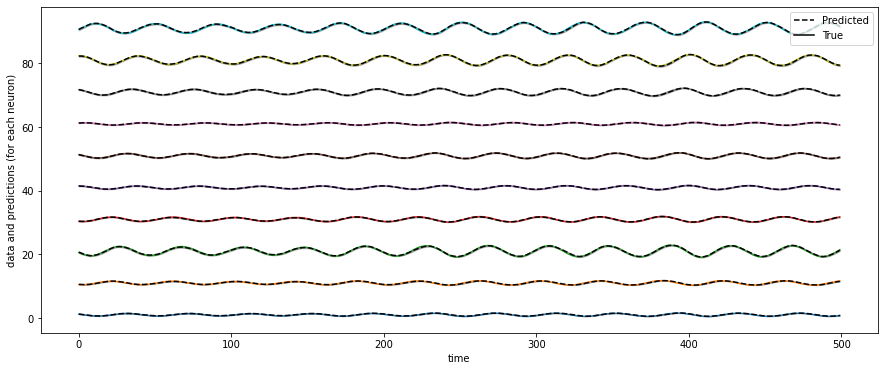

In [28]:
data_dim = data.shape[-1]

plt.figure(figsize=(15, 6))
plt.plot(Ey_true + 10 * np.arange(data_dim))
plt.plot(Ey + 10 * np.arange(data_dim), '--k')
for i in range(data_dim):
  plt.fill_between(np.arange(len(data)),
                   10 * i + Ey[:, i] - 2 * np.sqrt(Covy[:, i, i]),
                   10 * i + Ey[:, i] + 2 * np.sqrt(Covy[:, i, i]), 
                   color='k', alpha=0.25)
plt.xlabel("time")
plt.ylabel("data and predictions (for each neuron)")

plt.plot([0], '--k', label="Predicted") # dummy trace for legend
plt.plot([0], '-k', label="True")
plt.legend(loc="upper right")
plt.show()